In [1]:
from math import *
from numpy import sign
from tqdm import *
import numpy as np
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib
import matplotlib.cbook 
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as rand

from matplotlib import rc


rc('text', usetex=True)
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=20)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=20)

matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{graphics,graphicx,rotating}'
]

%matplotlib inline  



In [2]:
mylumi=37*1000
mycut='MEt > 800 & nj>= 2 & pt1 >100 & pt2>80 & pt4 > 50 & dphi < 0.4'

def binc(b):
    return np.sqrt(b[1:]*b[:-1])

def binw(b):
    return (b[1:]-b[:-1])

def get_sig(mZ, rinv, b, cut=mycut, lumi=mylumi, folder='../gen/tChannelTotalFinal/'):
    str1='{:d}'.format(mZ)
    if rinv >= .1 and rinv <=.9:
        str2='{:1.1f}'.format(rinv)  
    elif rinv != 1:
        str2='{:1.2f}'.format(rinv)
    else:
        str2='1.0'
    strevt='tchannel_total_M' + str1 + '_rinv' + str2 + '.evt'
    strmeta='tchannel_total_M' + str1 + '_rinv' + str2 + '.meta'
#    print(strevt)
#    strmeta='*MZ_' + str1 + '*rinv_' + str2 + '.meta'
    data_evt = pd.read_csv(folder+strevt, header=0, delimiter=',', skipinitialspace=True)
    data_meta = pd.read_csv(folder+strmeta, header=0, delimiter=',', skipinitialspace=True)
    data_evt = data_evt.query(cut)
#     cxn = 10**np.interp(mZ,intmass,intlogcxn) * (2*2*3)
    cxn = data_meta['cxn']*1
    scale=cxn*lumi/data_meta['nevt']
    result, _ =np.histogram(np.asarray(data_evt['MEt']), bins=b,
                            weights=np.repeat(scale[0],len(data_evt.index)))
#   apply a mask
    return np.append(result, result[-1])

mybins=10**np.linspace(log10(100),log10(8000),11)
# mybins1=10**np.linspace(log10(1000),log10(5000),10001)



def readfile(name, folder='ntuple_Tchannel/', lumi=mylumi, cxn=None):
    data = pd.read_csv(folder+name+'.evt', header=0, delimiter=',', skipinitialspace=True)
    data.meta = pd.read_csv(folder+name+'.meta', header=0, delimiter=',', skipinitialspace=True)
    if 'weight' in data.columns:
        data['weight'] *= (data.meta['cxn']*lumi/data.meta['sum_weight'])[0]
    else:
        data['weight'] = (data.meta['cxn']*lumi / data.meta['nevt'])[0]  
    if cxn is not None:
        data['weight'] = (cxn*lumi / data.meta['nevt'])[0]  
    return data

bkg_files = ['bkg_ttbar_dilep_0',  'bkg_ttbar_semilep_0',  'bkg_Wj_0',  'bkg_Zj_0']
bkg_files = [ readfile(f,folder='../analysis/BkgNtuplesWithMT/') for f in bkg_files ]

def get_bkg(b, cut=mycut, lumi=mylumi):
    bw = np.array(b[1:]-b[:-1])
    bc = np.sqrt(b[1:]*b[:-1])
    bkg_select=[ f.query(cut) for f in bkg_files ]
    result = np.array( [ np.histogram( np.asarray(f['MEt']), bins=b,
                            weights=f['weight'] )[0] for f in bkg_select ] )
    result = np.sum(result, axis=0)
    return np.append(result, result[-1])



In [ ]:
sig10 = 

In [3]:
from scipy.optimize import bisect
def limit(sig,bkg):
    if np.sum(sig)==0:
        return 1e99
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.02**2*qcd_1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    
    soln = bisect(func_root, -10.,20.)
    return 10**soln


rinv=np.array([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
#masses=[500,1000,2000,3000,4000,5000,7000,10000,20000,50000,100000] #[10000] #np.arange(300,3100,100)
masses=[500,1000,2000,4000,10000]

#basecut='MEt > 1000 & '
cutlist=[]

# scan over different cuts

for MEtcut in [800, 1000, 1200]:
    for pt2cut in [100, 120, 140]:
        for HTcut in [0, 200, 400]:
            for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
                c1 = 'MEt > ' + str(MEtcut) + ' & '
                c2 = 'pt2 > ' + str(pt2cut) + ' & '
                c3 = 'pt1 + pt2 + pt3 + pt4 > ' + str(HTcut) + ' & '
                cutlist = cutlist + [ c1 + c2 + c3 +  dphicut ]


result=np.zeros([len(rinv),len(masses)])
cutindex=np.zeros([len(rinv),len(masses)],dtype=int)

#get all the bkg first
bkg_list=[ get_bkg(mybins, cut=c) for c in cutlist ]


for im,m in tqdm(enumerate(masses)):
    for ir,r in enumerate(rinv[1:]):
        tempresult=np.array([ limit(get_sig(m,r,mybins,cut=c),bkg_list[i]) for i,c in enumerate(cutlist)])
        print("{:1.2f}, {:d}, {:1.3f}".format(r,m,np.amin(tempresult)))
        result[ir, im]=np.amin(tempresult)
        cutindex[ir, im]=np.argmin(tempresult)
        print("optimal cut: ",cutlist[cutindex[ir,im]])


0it [00:00, ?it/s]

0.10, 500, 1.406
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.20, 500, 0.749
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.30, 500, 0.719
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.40, 500, 0.749
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.50, 500, 0.356
('optimal cut: ', 'MEt > 1000 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.60, 500, 0.301
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.70, 500, 0.246
('optimal cut: ', 'MEt > 1200 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.80, 500, 0.216
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')
0.90, 500, 0.287
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')


1it [00:36, 36.06s/it]

1.00, 500, 0.169
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')
0.10, 1000, 3.778
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.20, 1000, 3.463
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.30, 1000, 1.414
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.40, 1000, 1.567
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.50, 1000, 1.080
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.60, 1000, 0.937
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.70, 1000, 0.785
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.80, 1000, 0.433
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')
0.90, 1000, 0.352
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 

2it [01:11, 35.76s/it]

1.00, 1000, 0.204
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')
0.10, 2000, 19.425
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.20, 2000, 13.206
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.30, 2000, 7.845
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.40, 2000, 6.887
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.50, 2000, 5.664
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.60, 2000, 4.805
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.70, 2000, 4.611
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.80, 2000, 3.959
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')
0.90, 2000, 2.574
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + p

3it [01:46, 35.73s/it]

1.00, 2000, 1.911
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')
0.10, 4000, 144.307
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.20, 4000, 77.863
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.30, 4000, 68.452
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.40, 4000, 61.165
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.50, 4000, 52.703
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.60, 4000, 65.942
('optimal cut: ', 'MEt > 1200 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.70, 4000, 58.704
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.80, 4000, 80.486
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.90, 4000, 132.067
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2

4it [02:23, 36.04s/it]

1.00, 4000, 73.694
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')
0.10, 10000, 3210.633
('optimal cut: ', 'MEt > 1000 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.20, 10000, 2563.966
('optimal cut: ', 'MEt > 1000 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.30, 10000, 1654.869
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.40, 10000, 1523.515
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.50, 10000, 1675.757
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.60, 10000, 1873.454
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.70, 10000, 2243.751
('optimal cut: ', 'MEt > 800 & pt2 > 140 & pt1 + pt2 + pt3 + pt4 > 0 & dphi < 0.4')
0.80, 10000, 4860.826
('optimal cut: ', 'MEt > 800 & pt2 > 100 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')
0.90, 10000, 4816.853
('optimal cut: ', 'MEt > 

5it [03:00, 36.18s/it]

1.00, 10000, 11159.779
('optimal cut: ', 'MEt > 800 & pt2 > 120 & pt1 + pt2 + pt3 + pt4 > 0 & dphi > 0.4')


In [4]:
masses_ary = []
rinv_ary = []
cuts_ary = []

for im, mass in enumerate(masses):
    for ir, r in enumerate(rinv):
        masses_ary.append(mass)
        rinv_ary.append(rinv)
        cuts_ary.append(cutlist[cutindex[ir,im]])

/group/hepheno/heptools/anaconda3/envs/venv_py27/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[  355.65278543   546.22197899   702.38555422   653.39835717   944.68958743
  1016.17115562  1056.2904016   1160.93263269  1291.76735524  1466.44528954
  2500.        ]
[    0.             0.           702.38555422   653.39835717   944.68958743
  1016.17115562  1056.2904016   1160.93263269  1291.76735524  1466.44528954
  2500.        ]


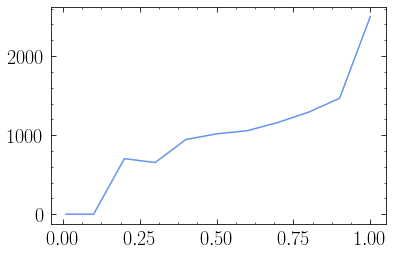

In [5]:
from scipy.optimize import fsolve

mass_limit=np.zeros(len(rinv))
for i,r in enumerate(rinv):
    mymass = np.insert(masses,0,0)
    masslist = np.insert(result[i],0,0)    
    mass_limit[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist), 2500)[0]

final_limit=mass_limit
print(mass_limit)


final_limit[0]=0
final_limit[1]=0
cutoff = final_limit/sqrt(.1)
plt.plot(rinv,final_limit)
print(final_limit)

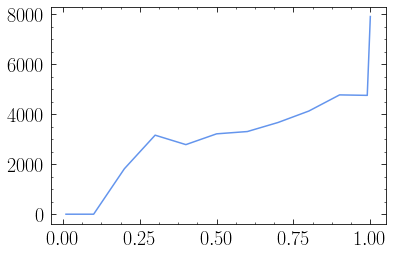

In [52]:
plt.plot(rinv,cutoff)